In [1]:
"""
A simple fully convolutional network to classify mnist dataset.
Implemented with PyTorch, Python 3.6, Jupyter Notebook.
"""

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.autograd as atgd
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
"""
loading training and testing data. 
"""

batchsize = 16
transform = transforms.Compose(
    [
    transforms.Resize((32,32)),    
    transforms.ToTensor(),
    ])

"""
download mnist dataset from internet 
"""
train_dataset = torchvision.datasets.MNIST(root = './data/mnist', 
                           train = True, 
                           transform = transform,
                           download = True) 
test_dataset = torchvision.datasets.MNIST(root = './data/mnist',
                           train = False,
                           transform = transform,
                           download = True)

"""
use dataloader to go through images and labels
"""
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)

print("The number of training images: ", len(train_loader)*batchsize)
print("The number of testing images: ", len(test_loader)*batchsize)
print("Data successfully loaded!")

The number of training images:  60000
The number of testing images:  10000
Data successfully loaded!


In [3]:
"""
The definition for network structure. This is a simple network using 3 convolutional
layers, 2 max pooling layers. 
We use cross entropy loss and SGD method for the BP. 
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)     
        self.conv3 = nn.Conv2d(16, 10, 5)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.conv3(x)
        return x

net = Net()
net = net.cuda()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 10, kernel_size=(5, 5), stride=(1, 1))
)


In [4]:
"""
This is a code section to show the output dimension and size of hidden layers. 
"""

H = 32
W = 128

H = H-net.conv1.kernel_size[0]+1
W = W - net.conv1.kernel_size[0]+1
print("after conv1: %d feature maps, each size %d * %d."
      % (net.conv1.out_channels,  H, W ) )
H /= 2 
W /= 2
print("after pool1: %d feature maps, each size %d * %d." 
      % (net.conv1.out_channels, H, W ) )

H = H-net.conv2.kernel_size[0]+1
W = W - net.conv2.kernel_size[0]+1
print("after conv2: %d feature maps, each size %d * %d."
      % (net.conv2.out_channels,  H, W ) )
H /= 2 
W /= 2
print("after pool2: %d feature maps, each size %d * %d." 
      % (net.conv2.out_channels, H, W ) )

H = H-net.conv3.kernel_size[0]+1
W = W - net.conv3.kernel_size[0]+1
print("after conv3: %d feature maps, each size %d * %d."
      % (net.conv3.out_channels,  H, W ) )

after conv1: 8 feature maps, each size 28 * 124.
after pool1: 8 feature maps, each size 14 * 62.
after conv2: 16 feature maps, each size 10 * 58.
after pool2: 16 feature maps, each size 5 * 29.
after conv3: 10 feature maps, each size 1 * 25.


In [5]:
"""
This function is used to compute the accuracy and loss for model(net) 
and input data (data_loader). 
"""

def compute_acc_loss(net, data_loader):
    correct = 0
    total = 0
    running_loss = 0
    for i, data in enumerate(data_loader, 0):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        outputs = outputs.view(-1,10)
        
        train_loss = criterion(outputs, labels)
        running_loss += train_loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batchsize
        correct += (predicted == labels).sum().item()
        
    return 100 * correct / total, running_loss / (len(data_loader) * batchsize) 

In [6]:
"""
This is the main process of training. We can define the epoch_num at the beginning
of training process.
"""

epoch_num = 20

for epoch in range(epoch_num): 
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()     
        outputs = net(inputs)
        outputs = outputs.view(-1,10)
        
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()


    """
    training accuracy and loss.
    save the accuracy and loss in lists to visualize the result
    """
    
    acc, loss = compute_acc_loss(net, train_loader)
    print("epoch number %d: training acc %.3f%%, training loss %.3f, " 
          % (epoch + 1, acc, loss), end = " ")
    
    acc, loss = compute_acc_loss(net, test_loader)
    print("testing acc %.3f%%, testing loss %.3f" % (acc, loss))

print("Training process end!")

epoch number 1: training acc 96.095%, training loss 0.008,  testing acc 96.380%, testing loss 0.007
epoch number 2: training acc 97.463%, training loss 0.005,  testing acc 97.620%, testing loss 0.005
epoch number 3: training acc 97.838%, training loss 0.004,  testing acc 97.800%, testing loss 0.004
epoch number 4: training acc 98.098%, training loss 0.004,  testing acc 98.200%, testing loss 0.003
epoch number 5: training acc 98.247%, training loss 0.004,  testing acc 98.200%, testing loss 0.004
epoch number 6: training acc 98.422%, training loss 0.003,  testing acc 98.550%, testing loss 0.003
epoch number 7: training acc 98.647%, training loss 0.003,  testing acc 98.610%, testing loss 0.003
epoch number 8: training acc 98.308%, training loss 0.003,  testing acc 98.350%, testing loss 0.003
epoch number 9: training acc 98.660%, training loss 0.003,  testing acc 98.340%, testing loss 0.003
epoch number 10: training acc 98.777%, training loss 0.002,  testing acc 98.620%, testing loss 0.003

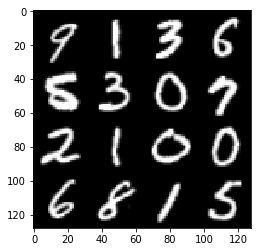

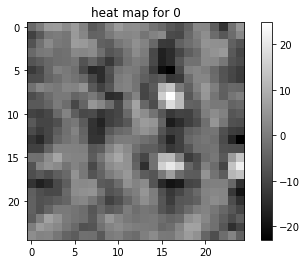

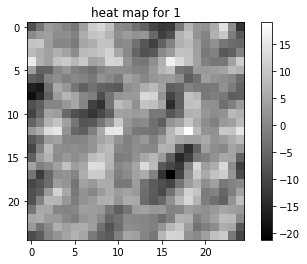

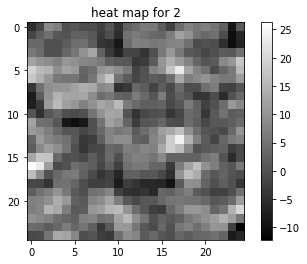

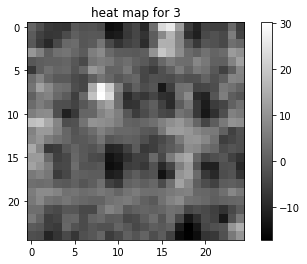

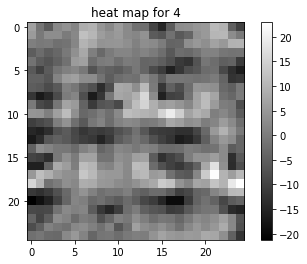

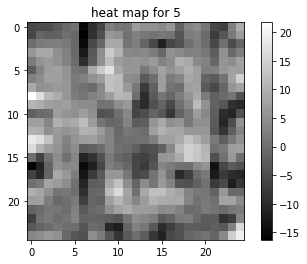

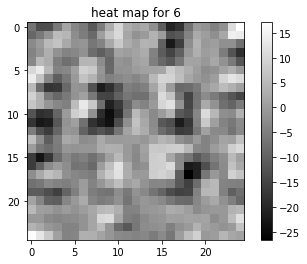

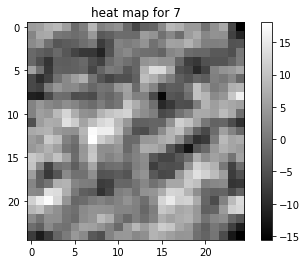

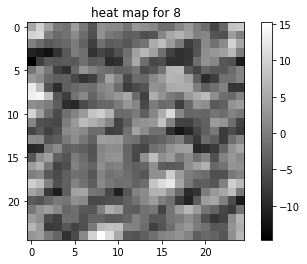

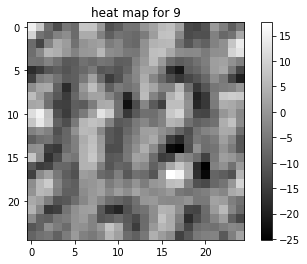

In [7]:
"""
Output the heat map of different input sizes.
Size can be set below by H and W. Then it will combine the images in mnist to a larger image. 
"""

H = 4 
W = 4
combine_loader = torch.utils.data.DataLoader(test_dataset, batch_size=W*H,
                                          shuffle=True, num_workers=1)

for data in combine_loader:
    images, _ = data
    images = images.cuda()
    for i in range(H):
        tmp = images[i*W]
        for j in range(1, W):
            tmp = torch.cat((tmp, images[i*W+j]), 2)
        
        if i == 0:
            result = tmp
        else:
            result = torch.cat((result, tmp),1)

    plt.figure(0)
    plt.imshow(result.squeeze(), cmap = "gray")
    result = result.view(1,1, H*32,W*32)
    outputs = net(result)
    outputs = outputs.squeeze(0)
    
    for i in range(0,10):
        plt.figure(i+1)
        plt.title("heat map for %d" % i)
        plt.imshow(outputs[i].detach(), cmap="gray")
        plt.colorbar()
    break